In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn.model_selection import  RandomizedSearchCV, StratifiedKFold

from lightgbm import LGBMClassifier


In [30]:
# Load the datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
full_X = pd.concat([X_train, X_test], ignore_index=True)



# Get the number of rows and columns for each DataFrame
rows_columns_X_train = X_train.shape
rows_columns_y_train = y_train.shape

# Output the number of rows and columns
print(f"X_train rows, columns: {rows_columns_X_train}")
print(f"y_train rows, columns: {rows_columns_y_train}")

X_train rows, columns: (10229, 26)
y_train rows, columns: (10229, 3)


# Data Exploration


In [31]:
# Merge the DataFrames on 'Identifiant'
df = pd.merge(X_train, y_train, on='Identifiant')
df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
df['EXPO'] = df['EXPO'].apply(lambda x: float(str(x).replace(',', '.')))
df['ft_24_categ'] = df['ft_24_categ'].str.strip()
df['ft_24_categ'] = df['ft_24_categ'].replace('.', np.nan)


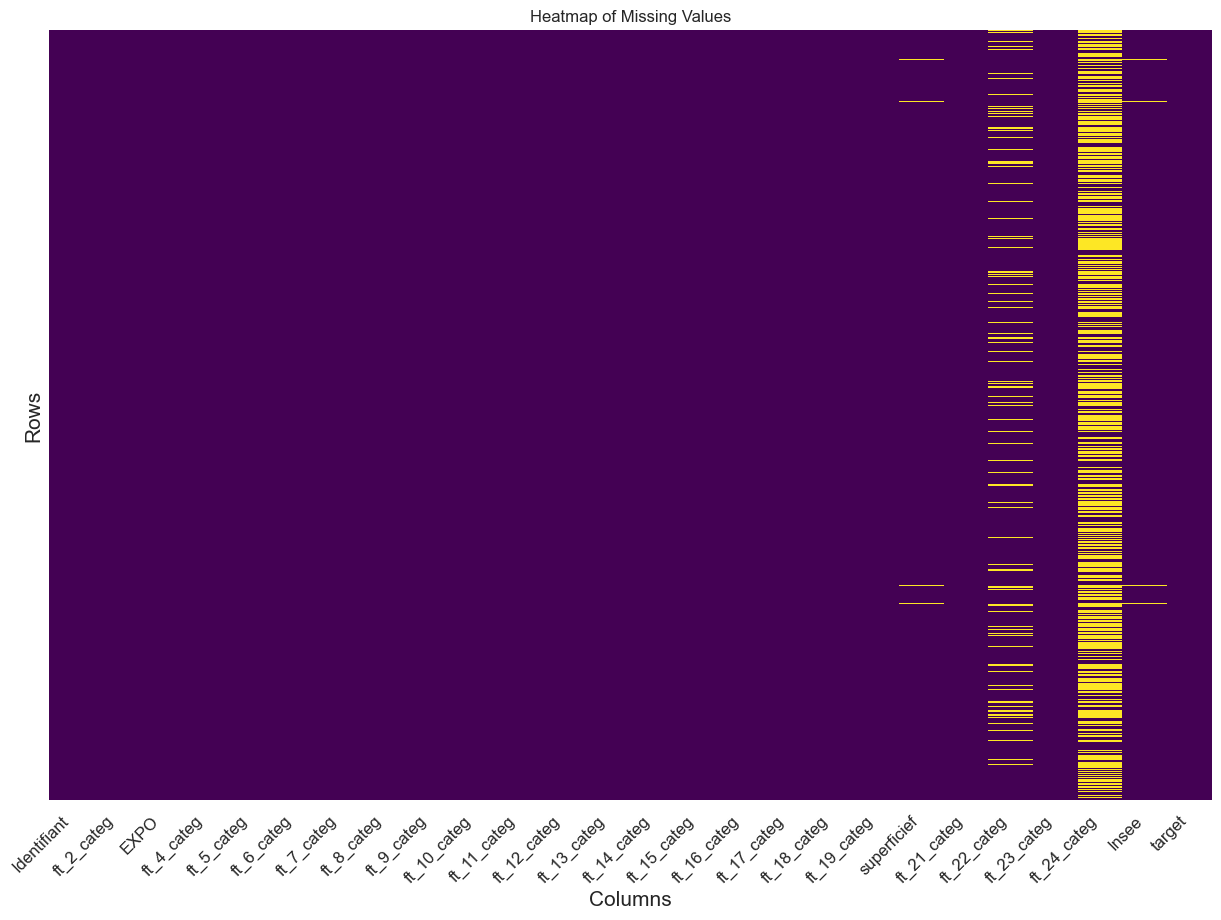

In [32]:
# Calculate a boolean DataFrame where True represents missing values
missing = df.isnull()

# Create a heatmap to visualize the missing values
plt.figure(figsize=(15, 10))  # Adjust the figure size as necessary
sns.heatmap(missing, cbar=False ,cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.xlabel('Columns', fontsize=15)
plt.ylabel('Rows', fontsize=15)
plt.show()


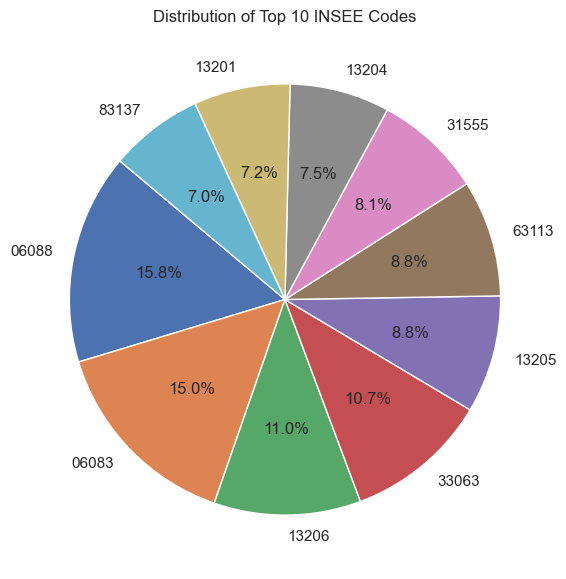

In [33]:
insee_counts = df['Insee'].value_counts()
top_10_insee_counts = insee_counts.head(10)
plt.figure(figsize=(10, 7)) 
plt.pie(top_10_insee_counts, labels=top_10_insee_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Top 10 INSEE Codes')
plt.show()


In [34]:
# Merge the DataFrames on 'Identifiant'
df = pd.merge(X_train, y_train, on='Identifiant')
df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','Identifiant','Insee'], inplace=True)
df['EXPO'] = df['EXPO'].apply(lambda x: float(str(x).replace(',', '.')))
df['ft_24_categ'] = df['ft_24_categ'].str.strip()
df['ft_24_categ'] = df['ft_24_categ'].replace('.', np.nan)
df.drop('ft_24_categ', axis=1, inplace=True)
df.to_csv('merged_data.csv', index=False)

In [35]:
target = 'target'
labels = ['Claimed','Not Claimed']
features = [i for i in df.columns.values if i not in [ target]]


In [9]:
original_df = df.copy(deep=True)
display(df.head())
print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,...,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,target
0,2014,1.000000,0,V,N,1,O,1,O,N,...,AUTRE,IDENTIQUE,V,base,2,1351.0,4,2012.0,0.0,0
1,2014,1.000000,0,V,V,V,V,V,V,V,...,V,V,N,base,2,1972.0,2,1980.0,0.0,1
2,2013,1.000000,1,V,V,V,V,V,V,V,...,V,V,N,base,2,1630.0,4,NaN,0.0,0
3,2013,0.246575,0,N,V,V,V,V,V,V,...,V,V,N,base,2,532.0,3,NaN,0.0,0
4,2015,1.000000,0,V,N,2,O,1,O,N,...,AUTRE,IDENTIQUE,V,base,2,1050.0,2,1972.0,0.0,0



Inference: The Dataset consists of 23 features & 10229 samples.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ft_2_categ   10229 non-null  int64  
 1   EXPO         10229 non-null  float64
 2   ft_4_categ   10229 non-null  int64  
 3   ft_5_categ   10229 non-null  object 
 4   ft_6_categ   10229 non-null  object 
 5   ft_7_categ   10229 non-null  object 
 6   ft_8_categ   10229 non-null  object 
 7   ft_9_categ   10229 non-null  object 
 8   ft_10_categ  10229 non-null  object 
 9   ft_11_categ  10229 non-null  object 
 10  ft_12_categ  10229 non-null  object 
 11  ft_13_categ  10229 non-null  object 
 12  ft_14_categ  10229 non-null  object 
 13  ft_15_categ  10229 non-null  object 
 14  ft_16_categ  10229 non-null  object 
 15  ft_17_categ  10229 non-null  object 
 16  ft_18_categ  10229 non-null  object 
 17  ft_19_categ  10229 non-null  int64  
 18  superficief  10110 non-null  float64
 19  ft_2

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['ft_19_categ'] = le.fit_transform(df['ft_19_categ'].astype(str))
df['ft_15_categ'] = le.fit_transform(df['ft_15_categ'].astype(str))
df['ft_16_categ'] = le.fit_transform(df['ft_16_categ'].astype(str))
df['ft_18_categ'] = le.fit_transform(df['ft_18_categ'].astype(str))
df['ft_13_categ'] = le.fit_transform(df['ft_13_categ'].astype(str))
df['ft_14_categ'] = le.fit_transform(df['ft_14_categ'].astype(str))
df['ft_17_categ'] = le.fit_transform(df['ft_17_categ'].astype(str))
df['ft_21_categ'] = le.fit_transform(df['ft_21_categ'].astype(str))
df['ft_5_categ'] = le.fit_transform(df['ft_5_categ'].astype(str))
df['ft_6_categ'] = le.fit_transform(df['ft_6_categ'].astype(str))
df['ft_7_categ'] = le.fit_transform(df['ft_7_categ'].astype(str))
df['ft_8_categ'] = le.fit_transform(df['ft_8_categ'].astype(str))
df['ft_9_categ'] = le.fit_transform(df['ft_9_categ'].astype(str))
df['ft_10_categ'] = le.fit_transform(df['ft_10_categ'].astype(str))
df['ft_11_categ'] = le.fit_transform(df['ft_11_categ'].astype(str))
df['ft_12_categ'] = le.fit_transform(df['ft_12_categ'].astype(str))
df['ft_2_categ'] = le.fit_transform(df['ft_2_categ'].astype(str))
df['ft_4_categ'] = le.fit_transform(df['ft_4_categ'].astype(str))
df['ft_21_categ'] = le.fit_transform(df['ft_21_categ'].astype(str))


# Handling NaN values by imputation
imputer = SimpleImputer(strategy='median')  # Imputing with median
df['ft_22_categ'] = imputer.fit_transform(df[['ft_22_categ']].astype(str))


In [12]:
import pandas as pd


smoothing = 10

mean_target_global = df['target'].mean()

agg = df.groupby('ft_23_categ')['target'].agg(['count', 'mean'])
agg.rename(columns={'count': 'n_category', 'mean': 'mean_target_category'}, inplace=True)


agg['smoothed_mean'] = (agg['mean_target_category'] * agg['n_category'] + mean_target_global * smoothing) / (agg['n_category'] + smoothing)


df['ft_23_categ'] = df['ft_23_categ'].map(agg['smoothed_mean'])
df['ft_23_categ'] = pd.to_numeric(df['ft_23_categ'], errors='coerce')



In [13]:
df.head()


,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,...,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,target
0,2,1.000000,0,2,0,0,1,0,1,0,...,0,0,2,1,1,1351.0,3,2012.0,0.229513,0
1,2,1.000000,0,2,2,3,2,3,2,2,...,1,1,0,1,1,1972.0,1,1980.0,0.229513,1
2,1,1.000000,1,2,2,3,2,3,2,2,...,1,1,0,1,1,1630.0,3,1970.0,0.229513,0
3,1,0.246575,0,0,2,3,2,3,2,2,...,1,1,0,1,1,532.0,2,1970.0,0.229513,0
4,3,1.000000,0,2,0,1,1,0,1,0,...,0,0,2,1,1,1050.0,1,1972.0,0.229513,0


In [14]:
#Checking the stats of all the columns

display(df.describe())

,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,...,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,target
count,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,...,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000,10110.000000,10229.000000,10229.000000,10229.000000,10229.000000
mean,1.646789,0.913672,0.281064,1.381464,1.132369,1.872617,1.565060,1.699286,1.564083,1.132564,...,0.566038,0.566038,0.910255,1.451657,0.938508,1818.152918,1.238049,1965.658422,0.226688,0.227002
std,1.380660,0.233806,0.449540,0.922788,0.991200,1.361340,0.497938,1.486249,0.500024,0.990976,...,0.495644,0.495644,0.993310,1.017031,0.240242,2272.111284,0.961589,31.497442,0.017609,0.418914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1545.000000,0.186529,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,500.000000,1.000000,1960.000000,0.229513,0.000000
50%,1.000000,1.000000,0.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1002.000000,1.000000,1970.000000,0.229513,0.000000
75%,3.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,2190.000000,2.000000,1980.000000,0.229513,0.000000
max,4.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,1.000000,1.000000,2.000000,4.000000,1.000000,30745.000000,3.000000,2016.000000,0.412408,1.000000


In [15]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

target            2
ft_19_categ       2
ft_4_categ        2
ft_16_categ       2
ft_15_categ       2
ft_17_categ       3
ft_14_categ       3
ft_12_categ       3
ft_11_categ       3
ft_13_categ       3
ft_8_categ        3
ft_6_categ        3
ft_5_categ        3
ft_10_categ       3
ft_9_categ        4
ft_7_categ        4
ft_21_categ       4
ft_18_categ       5
ft_2_categ        5
ft_23_categ       7
ft_22_categ     139
EXPO            467
superficief    2463
dtype: int64

In [16]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 3 numerical & 19 categorical features.


In [17]:
# Print the names of the numerical columns
print("Numerical columns:", nf)

Numerical columns: ['ft_22_categ', 'EXPO', 'superficief']


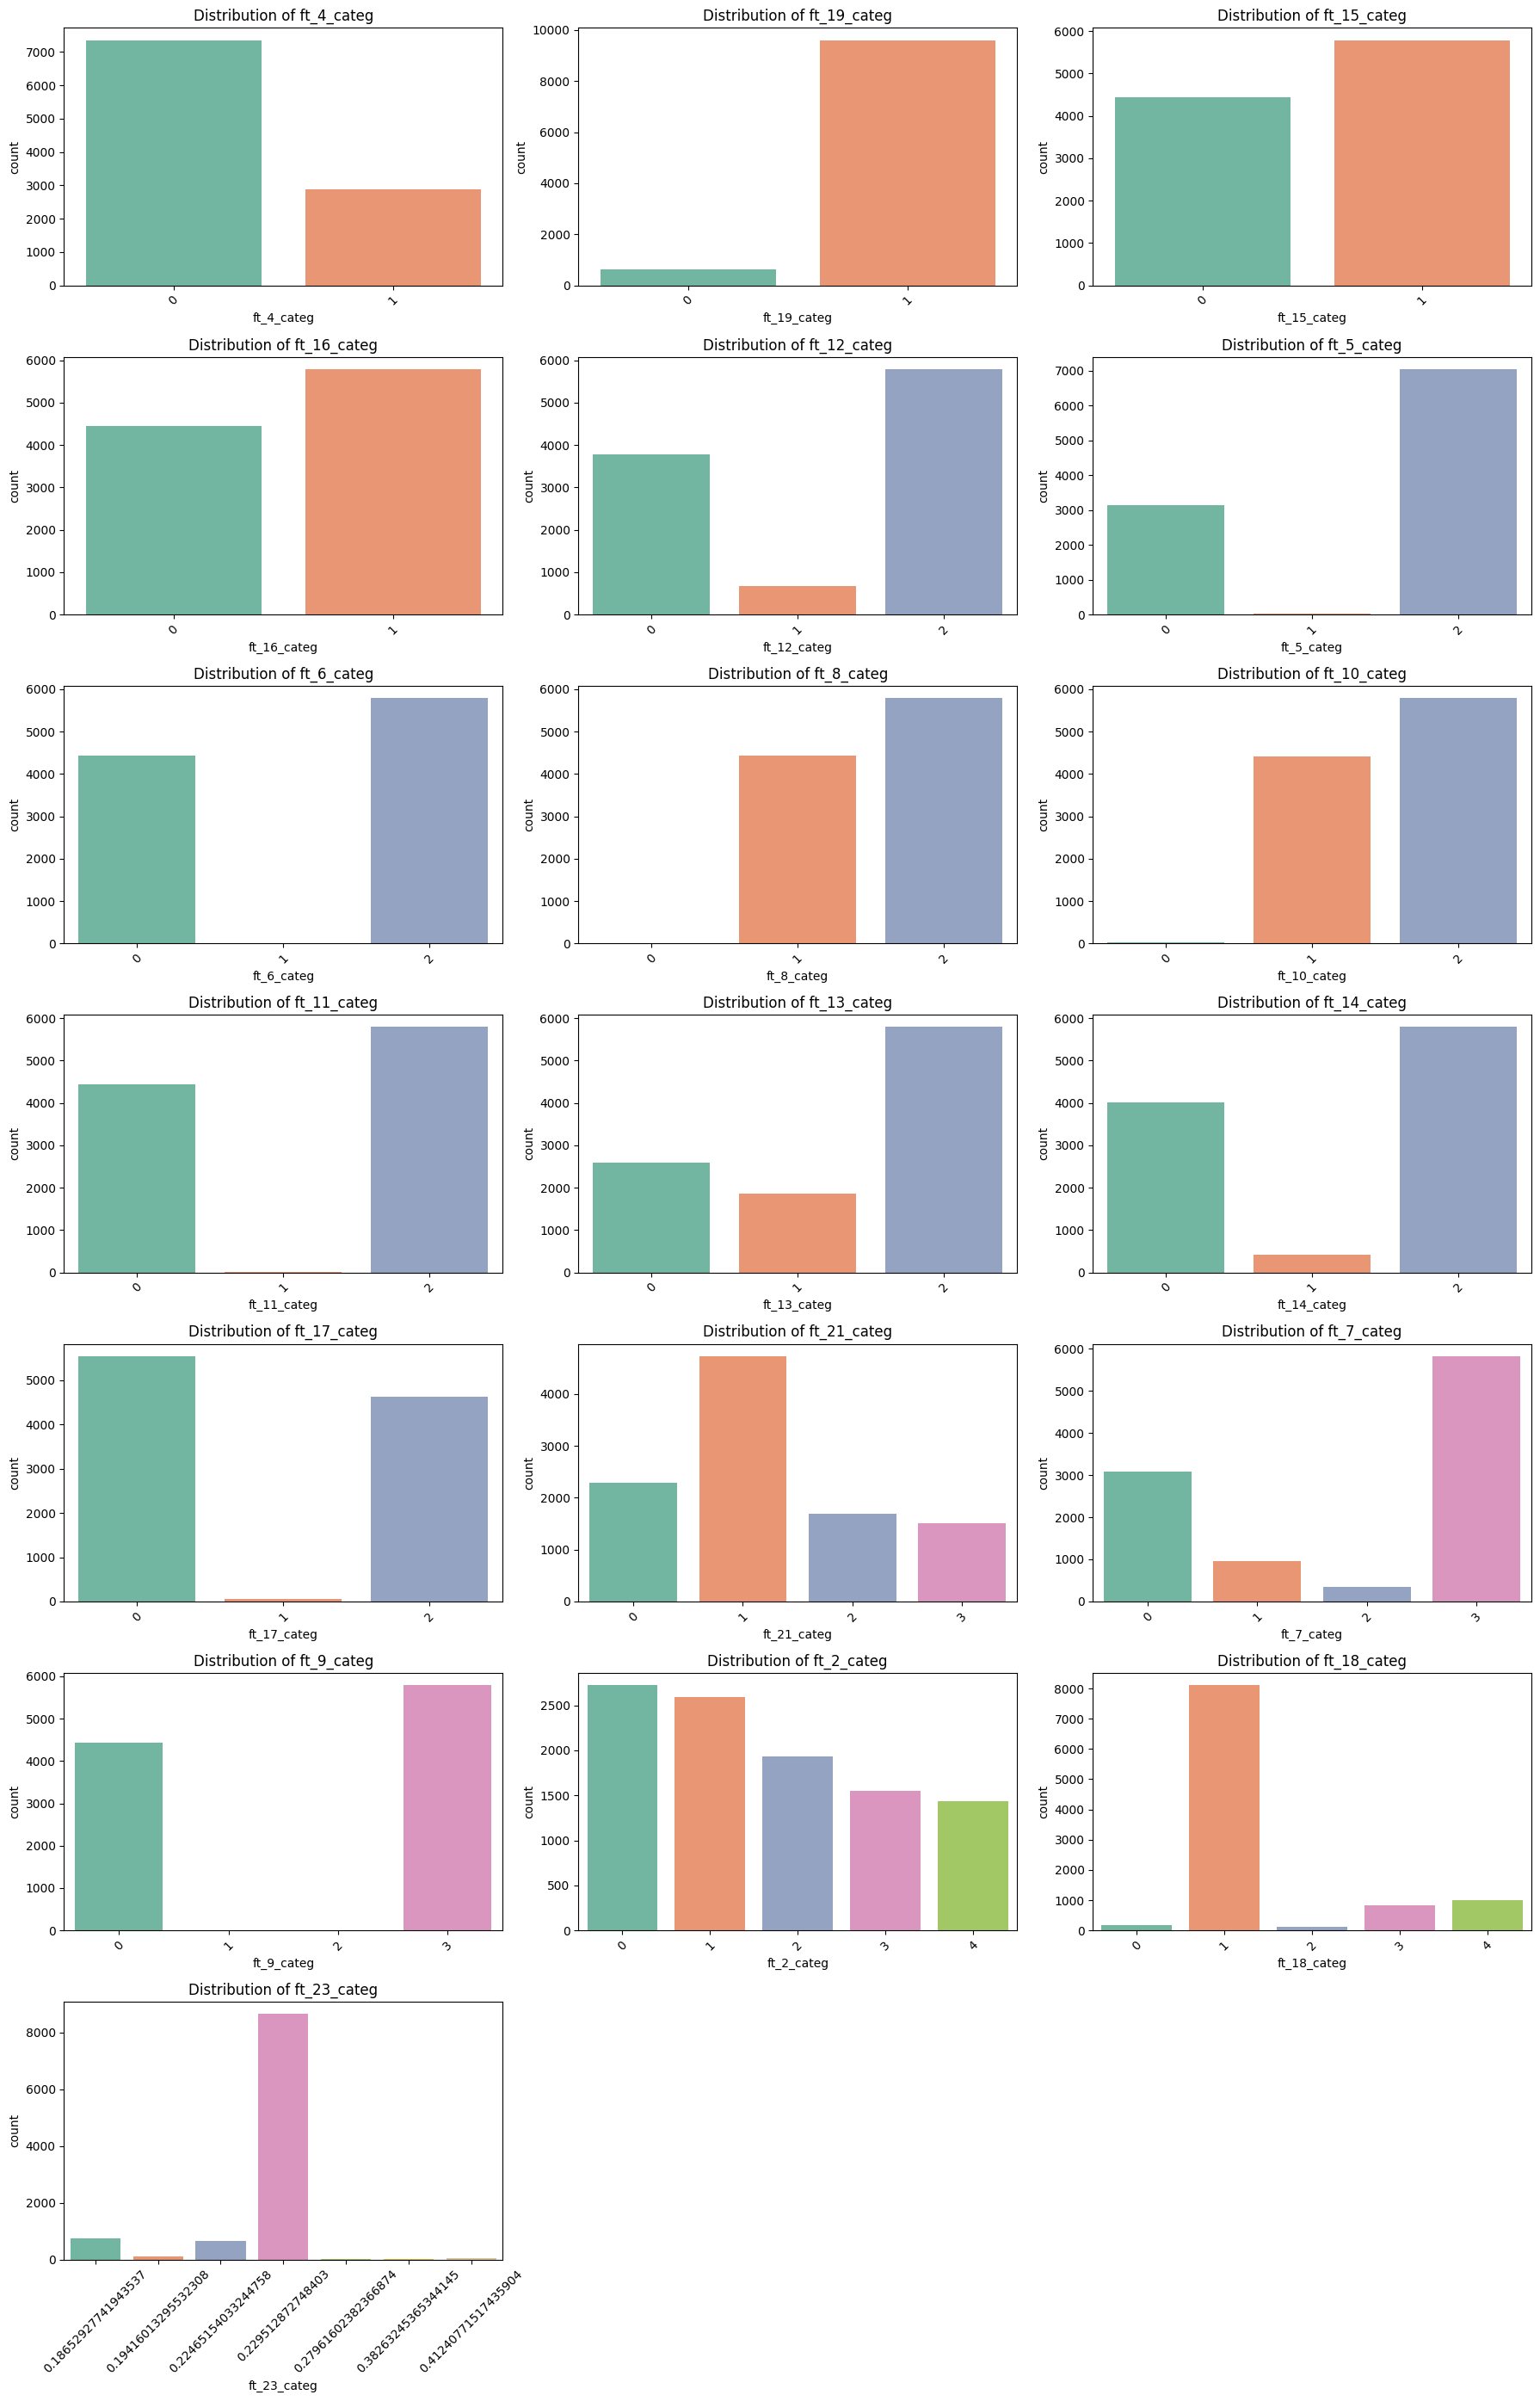

In [18]:

# Set the number of plots per row
plots_per_row = 3  # Adjust based on your preference and screen size

# Calculate the required number of rows to accommodate all categorical features
num_rows = len(cf) // plots_per_row + (len(cf) % plots_per_row > 0)

# Set the overall figure size
plt.figure(figsize=(18, num_rows * 4))  # Width, Height - adjust as needed

# Loop through the list of categorical features to create subplots
for i, feature in enumerate(cf):
    plt.subplot(num_rows, plots_per_row, i + 1)  # Rows, Columns, Plot number
    sns.countplot(x=feature, data=df, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)  # Rotate the labels to avoid overlap

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

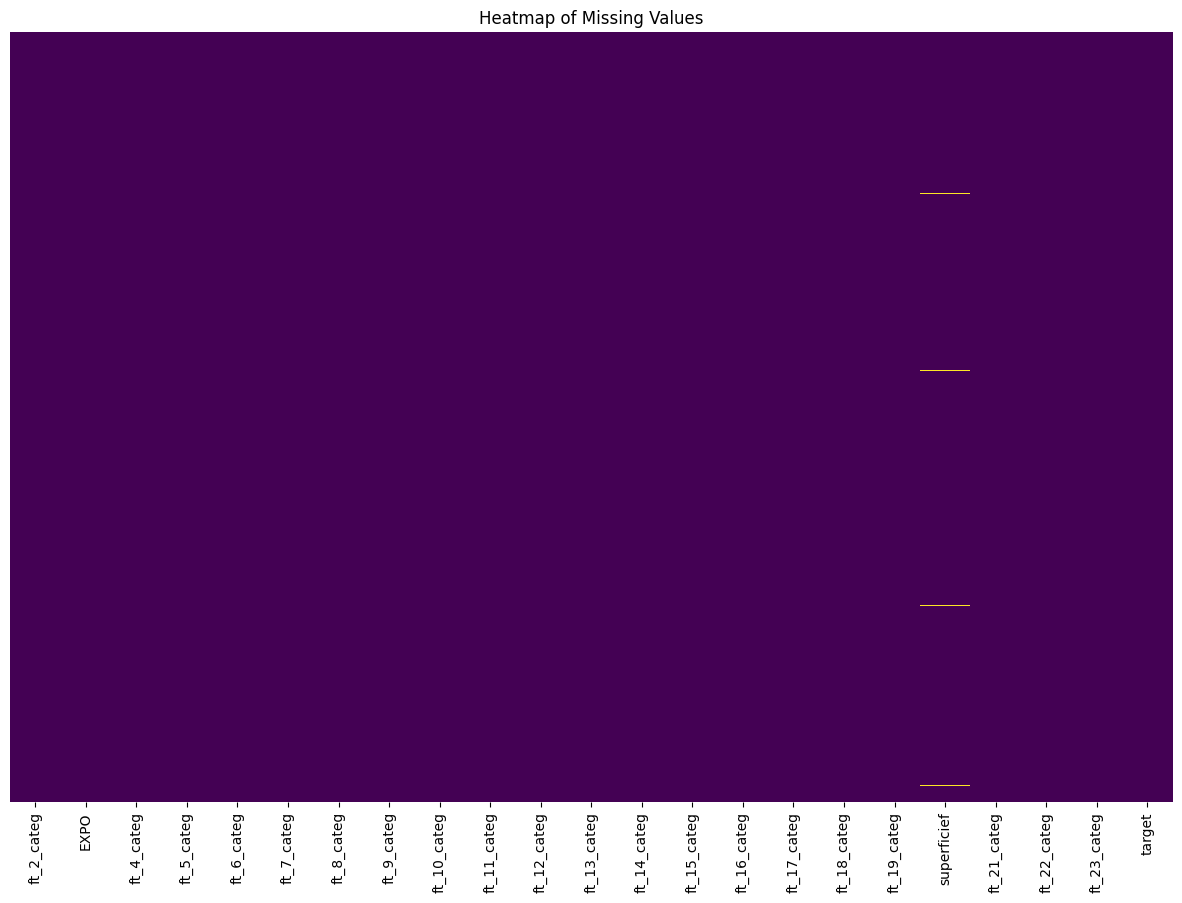

In [19]:


# Calculate a boolean DataFrame where True represents missing values
missing = df.isnull()

# Create a heatmap to visualize the missing values
plt.figure(figsize=(15, 10))  # Adjust the figure size as necessary
sns.heatmap(missing, cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()


In [20]:
# Drop rows where either 'Insee' or 'superficie' column has NaN values
df.dropna(subset=['superficief'], inplace=True)


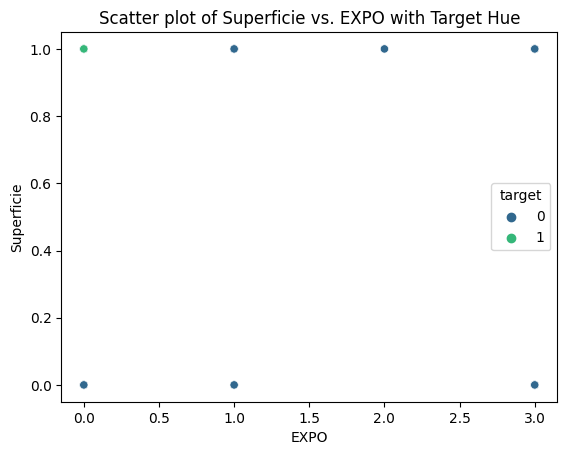

In [21]:
sns.scatterplot(data=df, x='ft_9_categ', y='ft_19_categ', hue='target', palette='viridis')

plt.title('Scatter plot of Superficie vs. EXPO with Target Hue')
plt.xlabel('EXPO')
plt.ylabel('Superficie')
plt.legend(title='target')
plt.show()

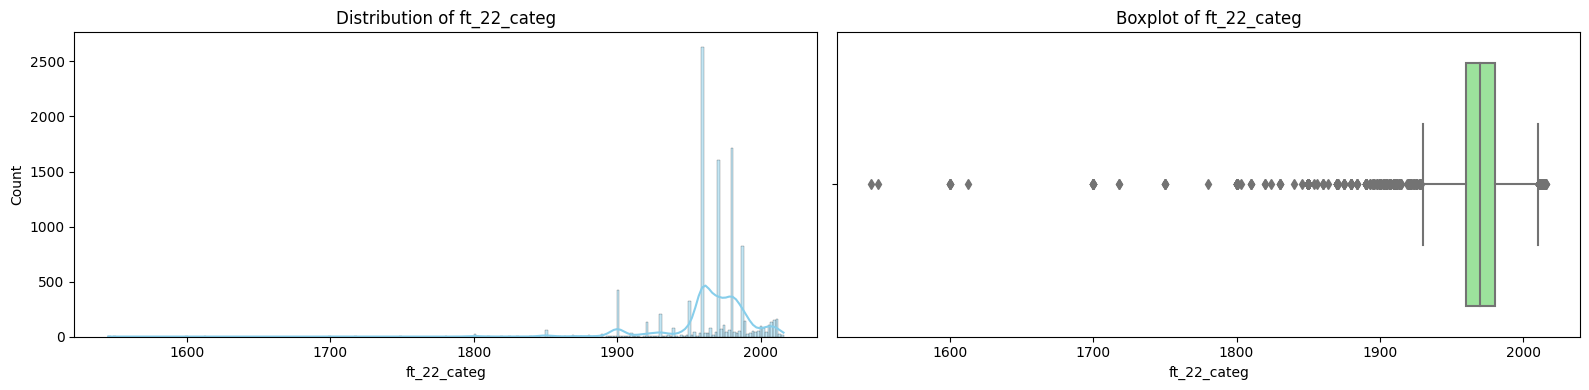

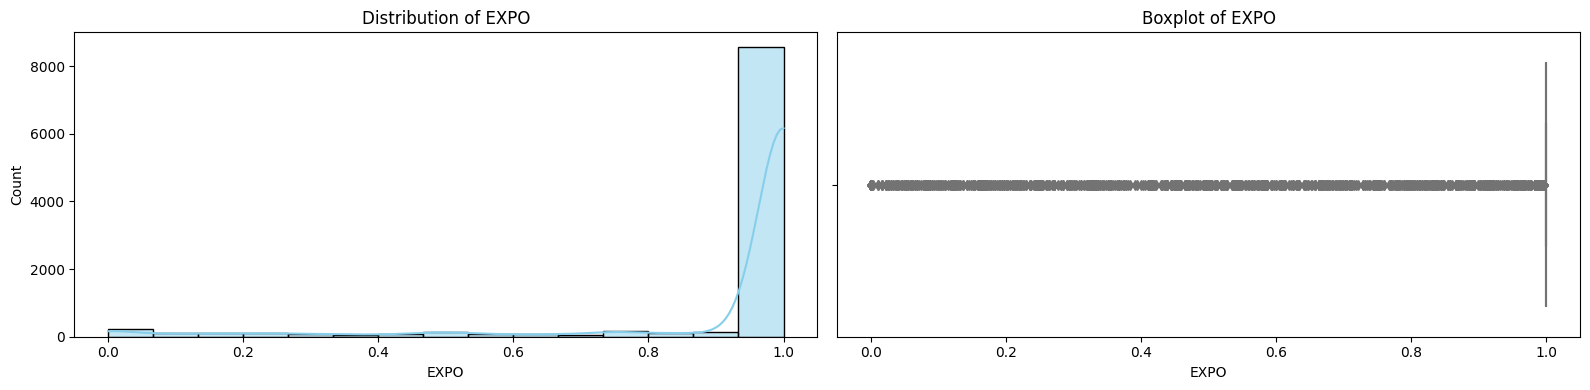

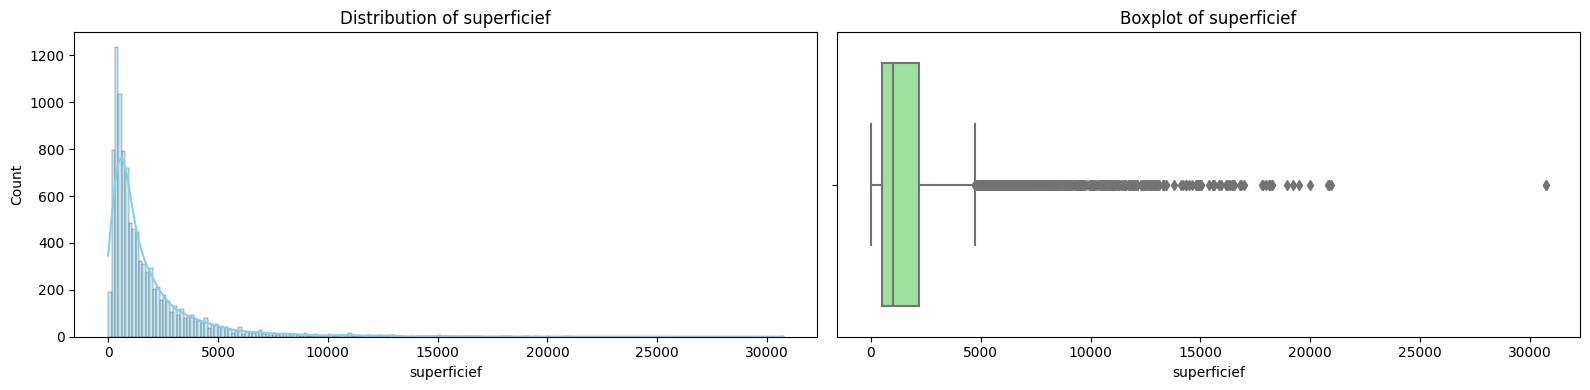

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
for feature in nf:
    if feature == 'Insee':
        continue
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.histplot(df[feature].dropna(), ax=axes[0], color='skyblue', kde=True)
    axes[0].set_title(f'Distribution of {feature}')
    sns.boxplot(x=df[feature], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {feature}')
    plt.tight_layout()
    plt.show()


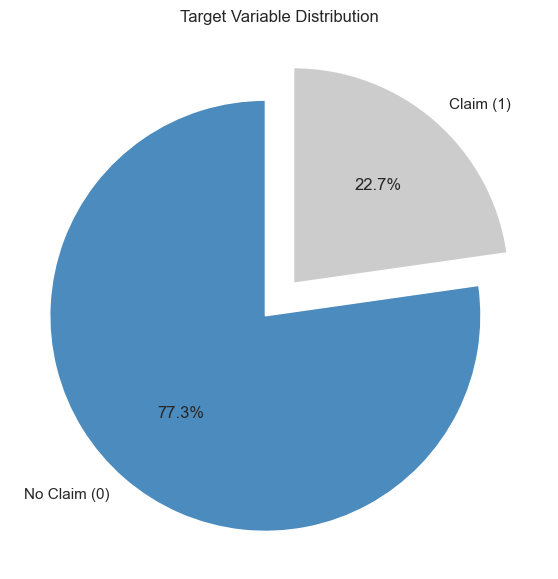

In [23]:

sns.set()
target_counts = df['target'].value_counts()
labels = ['No Claim (0)', 'Claim (1)']
explode = (0.1, 0.1)
plt.figure(figsize=(7, 7))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode,
        colors = ['#4B8BBE', '#CCCCCC'] 
)
plt.title('Target Variable Distribution')
plt.show()

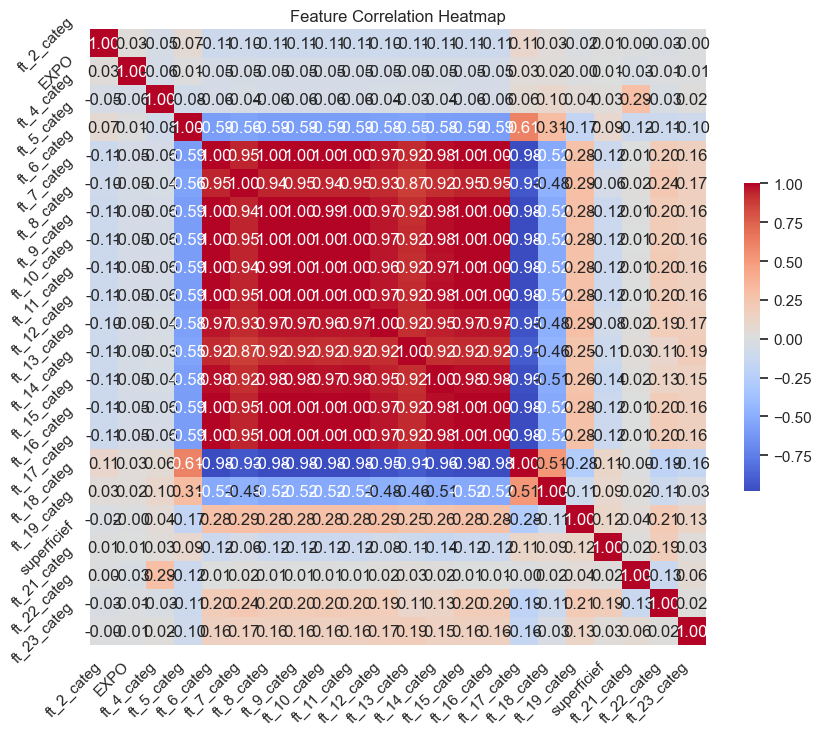

In [24]:

filtered_df = df[features]
corr_matrix = filtered_df.corr()



# Set the size of the figure
plt.figure(figsize=(10, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

# Adjust the layout for better readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.title('Feature Correlation Heatmap')

plt.show()



In [25]:
from sklearn.metrics import roc_auc_score

In [27]:

# Split the dataset into features and target variable
X = df.drop(columns=['target'])
y = df['target']

# Initialize the estimator
xgb_model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss')

# Setup cross-validation method
cv = StratifiedKFold(n_splits=5)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 4, 5, 6, 7],                # Maximum depth of each tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Subsample ratio of the training instances
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],            # Minimum loss reduction required to make a further partition on a leaf node
    'min_child_weight': [1, 5, 10]               # Minimum sum of instance weight (hessian) needed in a child
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=cv, scoring='accuracy', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)





Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.787141444114738


[0]	train-logloss:0.50275	val-logloss:0.51285
[1]	train-logloss:0.48476	val-logloss:0.49909
[2]	train-logloss:0.47289	val-logloss:0.49216
[3]	train-logloss:0.46371	val-logloss:0.48808
[4]	train-logloss:0.45784	val-logloss:0.48602
[5]	train-logloss:0.45278	val-logloss:0.48520
[6]	train-logloss:0.44918	val-logloss:0.48430
[7]	train-logloss:0.44580	val-logloss:0.48387
[8]	train-logloss:0.44271	val-logloss:0.48303
[9]	train-logloss:0.44013	val-logloss:0.48192
[10]	train-logloss:0.43844	val-logloss:0.48196
[11]	train-logloss:0.43720	val-logloss:0.48191
[12]	train-logloss:0.43499	val-logloss:0.48332
[13]	train-logloss:0.43200	val-logloss:0.48366
[14]	train-logloss:0.43058	val-logloss:0.48390
[15]	train-logloss:0.42987	val-logloss:0.48362
[16]	train-logloss:0.42904	val-logloss:0.48426
[17]	train-logloss:0.42794	val-logloss:0.48339
[18]	train-logloss:0.42533	val-logloss:0.48438
[19]	train-logloss:0.42455	val-logloss:0.48500
[20]	train-logloss:0.42177	val-logloss:0.48528
[21]	train-logloss:0.42

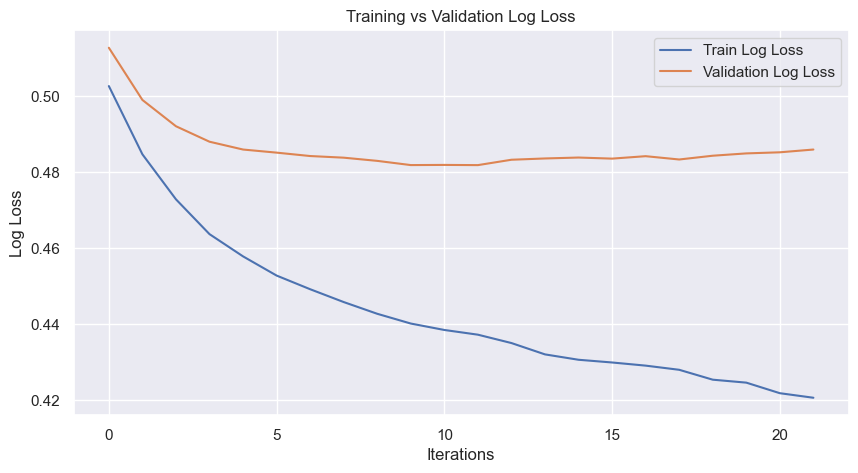

In [28]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and it's already defined
X = df.drop(columns=['target'])
y = df['target']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets to DMatrix, which is an internal data structure that XGBoost uses for efficiency and speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set up the parameters including the eval_metric as logloss for binary classification
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    # You can add more parameters here according to your model's needs
}

# Train the model and evaluate it on both training and validation sets
# Store the evaluation results to visualize them later
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=10,
                evals=[(dtrain, 'train'), (dval, 'val')], evals_result=evals_result, verbose_eval=True)

# Extract the log loss values for the training and validation sets from the evals_result
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['val']['logloss']

# Plot the training and validation log loss values over iterations
plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train Log Loss')
plt.plot(val_logloss, label='Validation Log Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.show()


In [24]:
# Split the dataset into features and target variable
X = df.drop(columns=['target'])
y = df['target']

# Import LightGBM
from lightgbm import LGBMClassifier

# Initialize the estimator
lgb_model = LGBMClassifier()

# Setup cross-validation method
cv = StratifiedKFold(n_splits=5)

# Assuming param_dist is defined elsewhere in your code and adapted for LightGBM parameters
# Example for LightGBM specific parameter distribution (this is just a placeholder, adjust according to your needs):
param_dist = {
   'num_leaves': [31, 127],
   'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1],
    'lambda_l2': [0, 1]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=100, cv=cv, scoring='accuracy', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


c:\Users\Mouad\anaconda3\envs\DS\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Mouad\anaconda3\envs\DS\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Mouad\anaconda3\envs\DS\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Mouad\anaconda3\envs\DS\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Info] Number of positive: 1840, number of negative: 6248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

In [27]:
# Assuming 'X' is your features and 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Get the prediction probabilities for the positive class
y_probs = random_search.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_probs)

# Calculate the normalized Gini coefficient
normalized_gini = 2 * roc_auc - 1

print("ROC AUC Score:", roc_auc)
print("Normalized Gini Coefficient:", normalized_gini)
print(y_probs.shape)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
ROC AUC Score: 0.7677420252741747
Normalized Gini Coefficient: 0.5354840505483494
(2022,)


In [28]:

X_test = pd.read_csv('X_test.csv')
def preprocessing_X_test(X_test):
    df_test = X_test
    
      # Placeholder for future target values

    
    df_test['EXPO'] = df_test['EXPO'].apply(lambda x: float(str(x).replace(',', '.')))
    df_test['ft_19_categ'] = le.fit_transform(df_test['ft_19_categ'].astype(str))
    df_test['ft_15_categ'] = le.fit_transform(df_test['ft_15_categ'].astype(str))
    df_test['ft_16_categ'] = le.fit_transform(df_test['ft_16_categ'].astype(str))
    df_test['ft_18_categ'] = le.fit_transform(df_test['ft_18_categ'].astype(str))
    df_test['ft_13_categ'] = le.fit_transform(df_test['ft_13_categ'].astype(str))
    df_test['ft_14_categ'] = le.fit_transform(df_test['ft_14_categ'].astype(str))
    df_test['ft_17_categ'] = le.fit_transform(df_test['ft_17_categ'].astype(str))
    df_test['ft_21_categ'] = le.fit_transform(df_test['ft_21_categ'].astype(str))
    df_test['ft_5_categ'] = le.fit_transform(df_test['ft_5_categ'].astype(str))
    df_test['ft_6_categ'] = le.fit_transform(df_test['ft_6_categ'].astype(str))
    df_test['ft_7_categ'] = le.fit_transform(df_test['ft_7_categ'].astype(str))
    df_test['ft_8_categ'] = le.fit_transform(df_test['ft_8_categ'].astype(str))
    df_test['ft_9_categ'] = le.fit_transform(df_test['ft_9_categ'].astype(str))
    df_test['ft_10_categ'] = le.fit_transform(df_test['ft_10_categ'].astype(str))
    df_test['ft_11_categ'] = le.fit_transform(df_test['ft_11_categ'].astype(str))
    df_test['ft_12_categ'] = le.fit_transform(df_test['ft_12_categ'].astype(str))
    df_test['ft_2_categ'] = le.fit_transform(df_test['ft_2_categ'].astype(str))
    df_test['ft_4_categ'] = le.fit_transform(df_test['ft_4_categ'].astype(str))
    df_test['ft_21_categ'] = le.fit_transform(df_test['ft_21_categ'].astype(str))


    # Handling NaN values by imputation
    imputer = SimpleImputer(strategy='median')  # Imputing with median
    df_test['ft_22_categ'] = imputer.fit_transform(df_test[['ft_22_categ']].astype(str))
    smoothing = 10
    df_test['ft_23_categ'] = le.fit_transform(df_test['ft_23_categ'].astype(str))
    
    Y_test = X_test[['Identifiant']].copy()
    Y_test['target'] = None
    df_test.drop(columns=['Unnamed: 0', 'ft_24_categ','Identifiant','Insee'], inplace=True)
    # Calculate the median of the 'superficief' column excluding NaN values
    median_superficief = df_test['superficief'].median()

    # Replace NaN values in the 'superficief' column with the calculated median
    df_test['superficief'].fillna(median_superficief, inplace=True)

    return df_test, Y_test


In [29]:
df_test, Y_test = preprocessing_X_test(X_test)
Y_test.to_csv('Y_test.csv', index=False)

# Assuming you have Y_test ready from previous steps and y_probs obtained
Y_test['target']  = random_search.predict_proba(X_test)[:, 1]
# Update the 'target' column in Y_test with the prediction probabilities


# Now Y_test contains the Identifiant and the predicted probabilities in 'target'
# Save Y_test to a CSV file
Y_test.to_csv('Y_prediction11.csv', index=True)

print("Updated Y_test with predictions has been saved to 'Updated_Y_test_with_predictions.csv'.")


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Updated Y_test with predictions has been saved to 'Updated_Y_test_with_predictions.csv'.


In [69]:
X_test.head()

,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,ft_11_categ,...,ft_15_categ,ft_16_categ,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,Insee
0,0,1.000000,1,2,0,0,1,0,1,0,...,0,0,2,3,1,2682.0,1,1970.0,0,78383
1,0,1.000000,1,2,0,0,1,0,1,0,...,0,0,2,1,1,2925.0,1,1960.0,0,78242
2,2,1.000000,1,2,2,3,2,3,2,2,...,1,1,0,1,1,525.0,3,1960.0,0,75120
3,1,0.161644,0,0,2,3,2,3,2,2,...,1,1,0,1,1,443.0,1,1980.0,0,11901
4,1,1.000000,0,0,2,3,2,3,2,2,...,1,1,0,1,1,1070.0,0,1969.5,0,42330


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and target variable respectively
# Example: X = df.drop(columns=['target']), y = df['target']

# Preprocess the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, input_dim=X.shape[1], activation='relu'),  # First hidden layer with 64 neurons
    Dense(32, activation='relu'),                        # Second hidden layer with 32 neurons
    Dense(16, activation='relu'),                        # Third hidden layer with 16 neurons
    Dense(1, activation='sigmoid')                       # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")





Epoch 1/100


809/809 [==============================] - 5s 4ms/step - loss: 0.4987 - accuracy: 0.7805 - val_loss: 0.4779 - val_accuracy: 0.7844
Epoch 2/100
809/809 [==============================] - 3s 4ms/step - loss: 0.4846 - accuracy: 0.7841 - val_loss: 0.4763 - val_accuracy: 0.7745
Epoch 3/100
809/809 [==============================] - 3s 3ms/step - loss: 0.4820 - accuracy: 0.7865 - val_loss: 0.4775 - val_accuracy: 0.7799
Epoch 4/100
809/809 [==============================] - 3s 3ms/step - loss: 0.4794 - accuracy: 0.7854 - val_loss: 0.4845 - val_accuracy: 0.7809
Epoch 5/100
809/809 [==============================] - 3s 3ms/step - loss: 0.4773 - accuracy: 0.7875 - val_loss: 0.4855 - val_accuracy: 0.7819
Epoch 6/100
809/809 [==============================] - 3s 3ms/step - loss: 0.4759 - accuracy: 0.7877 - val_loss: 0.4797 - val_accuracy: 0.7859
Epoch 7/100
809/809 [==============================] - 3s 3ms/step - loss: 0.4756 - accuracy: 0.7896 - val_loss: 0.4786 - val_accuracy: 0

In [34]:
scaler = StandardScaler().fit(X)  # Assuming X is your training features
X_test_scaled = scaler.transform(df_test)

# Use the trained neural network model to predict
# Since this is a binary classification task, model.predict will return the probability of the positive class
y_probs = model.predict(X_test_scaled)

# Update Y_test with the prediction probabilities
# Assuming Y_test is prepared to receive these probabilities
Y_test['target'] = y_probs.flatten()

# Save Y_test to a CSV file with prediction probabilities
Y_test.to_csv('Y_prediction111.csv', index=True)

107/107 [==============================] - 0s 2ms/step
